<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/SCAREDUnetLosses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
rm best_model.pth.tar

rm: cannot remove 'best_model.pth.tar': No such file or directory


In [2]:
rm SCARED.zip

rm: cannot remove 'SCARED.zip': No such file or directory


In [3]:
rm -rf SCARED

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


#Installation

In [5]:
!pip -q install torchmetrics
#!pip install pytorch-ignite

     |████████████████████████████████| 529 kB 4.7 MB/s 


#Download Data

In [6]:
import gdown
url = 'https://drive.google.com/uc?id=1LX26iq2qBjvxnbRicXPXidNKclWtQJ2E'
gdown.download(url,'SCARED.zip',quiet=True) 
import os
if not os.path.exists('/content/SCARED/'):
  !unzip -q SCARED.zip 

In [7]:
import tarfile
import re
from collections import OrderedDict
from tqdm import tqdm
import json
import numpy as np
import gdown
json_tar_gz_url = 'https://drive.google.com/uc?id=1rrswaVdzir4feGNvDmvW56iql-L0saZL'
gdown.download(json_tar_gz_url,'d3k1_json',quiet=True) 

poses= []
with tarfile.open('d3k1_json', "r:gz") as frame_data:
  samples = frame_data.getmembers()
  for sample in tqdm(samples, desc="loading pose data", leave=False):
      with frame_data.extractfile(sample) as sample_json:
          pose = np.array(json.loads(sample_json.read())["camera-pose"])
          poses.append(pose) 
print(len(poses),pose)

329 [[ 6.79565802e-01 -7.31499864e-01 -5.56609482e-02 -5.61911743e+00]
 [ 7.32502844e-01  6.80755367e-01 -3.39599501e-03 -3.42786864e-01]
 [ 4.03758211e-02 -3.84639001e-02  9.98443636e-01 -3.27258599e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


#Prepare Dataloader

torch.Size([3, 256, 320]) torch.Size([256, 320]) tensor(0.1490) tensor(0.8863)


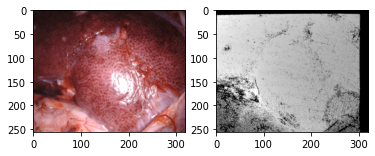

In [8]:
from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2

class MyDataset(Dataset):
    def __init__(self, path_depth=None, transform=None):
        self.path_depth = path_depth
        self.transform = transform

    def __len__(self):
      return len(self.path_depth)   

    def __getitem__(self, i):
        depth = tifffile.imread(self.path_depth[i])[:,:,2]
        depth = np.nan_to_num(depth, posinf=0, neginf=0)
        depth = cv2.applyColorMap(cv2.convertScaleAbs(depth, alpha=2.5), cv2.COLORMAP_JET)
        depth = Image.fromarray(depth).convert('L')
        path_ = self.path_depth[i]
        path_ = path_.replace('left', 'Left')
        path_ = path_.replace('right', 'Right')
        img = Image.open(path_[:-14] + 'Image.png').convert('RGB')
        if self.transform:
            img, depth = self.transform(img), self.transform(depth)
        return img, depth

transform_all = transforms.Compose([
    transforms.Resize((256, 320)),
    transforms.ToTensor(),
])

path_depth_all = glob('SCARED/*.tiff')
path_depth_train = path_depth_all[:56]
path_depth_valid = path_depth_all[56:]

dataset_train = MyDataset(path_depth=path_depth_train, transform=transform_all)
dataset_valid = MyDataset(path_depth=path_depth_train, transform=transform_all)
plt.subplot(121), plt.imshow(dataset_train[0][0].permute(1,2,0))
plt.subplot(122), plt.imshow(dataset_train[0][1][0], cmap='gray')
print(dataset_train[0][0].shape, dataset_train[0][1][0].shape, dataset_train[0][1].min(), dataset_train[0][1].max())

train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=2)

#Arguments

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt

def seed_everything(seed=42):
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = argparse.ArgumentParser(description='Kitti Interpolation Training')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=64, type=int, help='batch size')
    parser.add_argument('--valid_batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--max_epochs', default=120, type=int, help='epoch number')
    parser.add_argument('--ckpt', type=str, default='best_model.pth.tar', help='total gpu')
    parser.add_argument('--criterion', type=str, default='bce', help='total gpu')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

#Training

*abs error*: The difference between the predicted and the gt.             
*rel error*: The ratio of abs error and the actual gt.

mse = $\frac{1}{n}\sum_{i=1}^{n}(pred_i - gt_i)^2$

mae = $\frac{1}{n}\sum_{i=1}^{n}|pred_i - gt_i|$

**sq rel** =  $\frac{1}{n}\sum_{i=1}^{n}(pred_i - gt_i)^2/gt_i$

**abs rel** = $\frac{1}{n}\sum_{i=1}^{n}|pred_i - gt_i|/gt_i$

**rmse** = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(pred_i - gt_i)^2}$

**rmse log** = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(\log pred_i - \log gt_i)^2}$

In [10]:
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import mean_absolute_error

import torchvision.transforms as transforms
from PIL import Image
import os


import math
import torch.nn.functional as F
import numpy as np
from torchmetrics import StructuralSimilarityIndexMeasure

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class SSIM_Loss_Lib(nn.Module):
    def __init__(self, data_range=1):
        super().__init__()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=data_range)

    def forward(self, img1, img2):
        return 1 - self.ssim(img1, img2)



def train(model, trainloader, optimizer, criterion):
    model.train()
    for i_batch, s_batch in enumerate(trainloader):
        image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
        outputs = model(image_batch)
        loss = criterion(outputs, label_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    ssim = StructuralSimilarityIndexMeasure(data_range=1)
    mse_all = []
    ssim_all = []
    rmse_all = []
    rmselog_all = []
    mae_rel_all = []
    mse_rel_all = []
    with torch.no_grad():
        for i_batch, s_batch in enumerate(testloader):
            image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
            outputs = model(image_batch)
            outputs = nn.Sigmoid()(outputs)
            mse = nn.MSELoss()(outputs, label_batch)
            mse_all.append(mse.item())
            ssim_all.append(ssim(outputs.detach().cpu(), label_batch.detach().cpu()).item())
            rmse_all.append(math.sqrt(mse.item()))
            rmselog_all.append(math.sqrt(nn.MSELoss()(torch.log(outputs), torch.log(label_batch)).item()))
            mse_rel_all.append(mse.item() / label_batch[i_batch][0].detach().cpu().numpy())
            mae_rel_all.append(nn.L1Loss()(outputs, label_batch).item() / label_batch[i_batch][0].detach().cpu().numpy())
        return np.mean(mse_all), np.mean(ssim_all), np.mean(rmse_all), np.mean(rmselog_all), np.mean(mse_rel_all),  np.mean(mae_rel_all[0])


def main():
    seed_everything()
    args = get_args()

    path_depth_all = glob('SCARED/*.tiff')
    eighty_percent = math.ceil(len(path_depth_all)*0.8)
    path_depth_train = path_depth_all[:eighty_percent]
    path_depth_valid = path_depth_all[eighty_percent:]

    dataset_train = MyDataset(path_depth=path_depth_train, transform=transform_all)
    dataset_valid = MyDataset(path_depth=path_depth_valid, transform=transform_all)

    train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=2)
    valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=2)

    print("Sample size- Train:%d, Valid: %d"%(len(dataset_train), len(dataset_valid)))
    #github: https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
            in_channels=3, out_channels=1, init_features=32, pretrained=False)
    model.to(device)

    args.criterion = 'l1'

    if args.criterion == 'mse':        
        criterion = nn.MSELoss().to(device)
    elif args.criterion == 'l1':        
        criterion = nn.L1Loss().to(device)
    elif args.criterion == 'ssim':        
        criterion = SSIM_Loss_Lib(data_range=1.0).to(device)
    elif args.criterion == 'bce':
        criterion = nn.BCELoss().to(device)
    
    #optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    #criterion = nn.BCELoss().to(device)
    #best_mse, best_ssim, best_epoch = np.inf, np.inf, 0
    best_mse, best_ssim, best_rmse, best_rmselog, best_mse_rel, best_mae_rel, best_epoch = np.inf, np.inf, np.inf,np.inf,np.inf,np.inf,0
    for epoch_num in range(args.max_epochs):
        
        train(model, train_loader, optimizer, criterion)
        #mse, ssim = test(model, valid_loader)
        mse, ssim, rmse, rmselog, mse_rel, mae_rel = test(model, valid_loader)
        if mse < best_mse:
            best_mse = mse
            #best_ssim = ssim
            best_epoch = epoch_num
            torch.save(model.state_dict(), args.ckpt)
        if ssim < best_ssim:
            best_ssim = ssim
            best_epoch = epoch_num
     
        if rmse < best_rmse:
            best_rmse = rmse
            best_epoch = epoch_num
        
        if rmselog < best_rmselog:
            best_rmselog = rmselog
            best_epoch = epoch_num

        if mse_rel < best_mse_rel:
            best_mse_rel = mse_rel
            best_epoch = epoch_num
        if mae_rel < best_mae_rel:
            best_mae_rel = mae_rel
            best_epoch = epoch_num

           
        # print('Epoch:{}, Curr MSE(L2):{:.6f}, Curr SSIM:{:.6f}, Best MSE(L2):{:.6f}, Best SSIM:{:.6f}, Best Epoch:{}, Criterion:{}, Lr:{}'.
        #         format(epoch_num, mse, ssim, best_mse, best_ssim, best_epoch, args.criterion, optimizer.param_groups[0]['lr']))
        print('Epoch:{}, Curr MSE(L2):{:.6f}, Best RMSE:{:.6f}, RMSElog:{:.6f}, sq rel:{:.6f}, abs rel:{:.6f}, MSE(L2):{:.6f}, SSIM:{:.6f},  Best Epoch:{}, Criterion:{}, Lr:{}'.
                format(epoch_num, mse, best_rmse, best_rmselog, best_mse_rel, best_mae_rel, best_mse, best_ssim,  best_epoch, args.criterion, optimizer.param_groups[0]['lr']))

if __name__ == "__main__":
    main()

Sample size- Train:56, Valid: 14


/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip


Epoch:0, Curr MSE(L2):0.101871, Best RMSE:0.319173, RMSElog:1.022933, sq rel:0.269157, abs rel:0.698311, MSE(L2):0.101871, SSIM:0.276837,  Best Epoch:0, Criterion:l1, Lr:0.0001
Epoch:1, Curr MSE(L2):0.102151, Best RMSE:0.319173, RMSElog:1.022933, sq rel:0.269157, abs rel:0.698311, MSE(L2):0.101871, SSIM:0.276762,  Best Epoch:1, Criterion:l1, Lr:0.0001
Epoch:2, Curr MSE(L2):0.102420, Best RMSE:0.319173, RMSElog:1.022933, sq rel:0.269157, abs rel:0.698311, MSE(L2):0.101871, SSIM:0.276675,  Best Epoch:2, Criterion:l1, Lr:0.0001
Epoch:3, Curr MSE(L2):0.102684, Best RMSE:0.319173, RMSElog:1.022933, sq rel:0.269157, abs rel:0.698311, MSE(L2):0.101871, SSIM:0.276582,  Best Epoch:3, Criterion:l1, Lr:0.0001
Epoch:4, Curr MSE(L2):0.102950, Best RMSE:0.319173, RMSElog:1.022933, sq rel:0.269157, abs rel:0.698311, MSE(L2):0.101871, SSIM:0.276479,  Best Epoch:4, Criterion:l1, Lr:0.0001
Epoch:5, Curr MSE(L2):0.103225, Best RMSE:0.319173, RMSElog:1.022933, sq rel:0.269157, abs rel:0.698311, MSE(L2):0.

# comparative visulization

In [13]:
import gdown
url1 = 'https://drive.google.com/uc?id=1eOcmOO0osrOwwoxqZ9ujdEFhQB1FL7Hs'
gdown.download(url1,'bce_epoch110',quiet=True)
url2 = 'https://drive.google.com/uc?id=1_8XF5Moz-CCCvOiWfypUwjpFe-I8zWr6'
gdown.download(url2,'mae_epoch108',quiet=True)
url3 = 'https://drive.google.com/uc?id=1vTKtu5OWdARAWOENgIW4o6AjGYrkZOSD'
gdown.download(url3,'mse_epoch119',quiet=True)
url4 = 'https://drive.google.com/uc?id=1fNyyPYJ7SVwzAXTEGRQvw962pJYF8AI8'
gdown.download(url4,'ssim_epoch118',quiet=True)

(input, label) = dataset_valid[42]
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
            in_channels=3, out_channels=1, init_features=32, pretrained=False)
model.load_state_dict(torch.load('bce_epoch110'))
model.cuda()
prediction = model(input[None].cuda())
model.load_state_dict(torch.load('mae_epoch108'))
model.cuda()
prediction2 = model(input[None].cuda())
model.load_state_dict(torch.load('mse_epoch119'))
model.cuda()
prediction3 = model(input[None].cuda())
model.load_state_dict(torch.load('ssim_epoch118'))
model.cuda()
prediction4 = model(input[None].cuda())

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


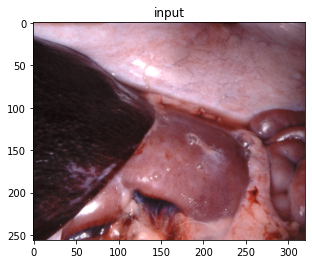

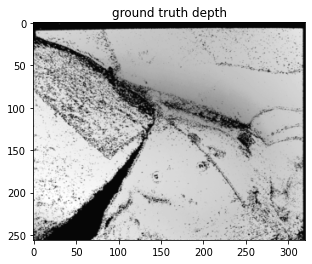

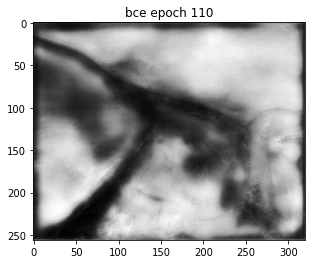

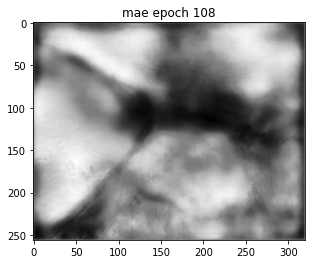

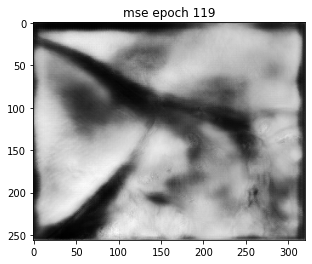

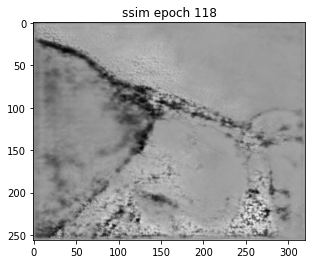

In [14]:
plt.imshow(input.permute(1,2,0)), plt.title('input')
plt.show()
plt.imshow(label[0], cmap='gray'), plt.title('ground truth depth')
plt.show()
plt.plot(),plt.imshow(prediction[0][0].detach().cpu(), cmap='gray'), plt.title('bce epoch 110')
plt.show()
plt.plot(), plt.imshow(prediction2[0][0].detach().cpu(),cmap='gray'), plt.title('mae epoch 108')
plt.show()
plt.plot(), plt.imshow(prediction3[0][0].detach().cpu(),cmap='gray'), plt.title('mse epoch 119')
plt.show()
plt.plot(), plt.imshow(prediction4[0][0].detach().cpu(),cmap='gray'), plt.title('ssim epoch 118')
plt.show()